# Data Cleansing

In [1]:
import pandas as pd
import numpy as np
import h5py
import os
import statsmodels.api as sm
import time

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco

In [3]:
path = '/Users/heshan/Desktop/Portfolio Optimization/'
os.chdir(path)

In [4]:
data_aapl = pd.read_csv('AAPL.csv')
data_goog = pd.read_csv('GOOG.csv')
#data_tsla = pd.read_csv('TSLA.csv')
#data_ms = pd.read_csv('MS.csv')
data_market = pd.read_csv('SP500.csv')

In [5]:
#datadict = {'AAPL':data_aapl, 'GOOG':data_goog, 'TSLA':data_tsla, 'MS':data_ms, 'Market':data_market}
datadict = {'AAPL':data_aapl, 'GOOG':data_goog, 'Market':data_market}
keylist = ['AAPL','GOOG', 'Market'] #['AAPL','GOOG','TSLA','MS','Market']

In [6]:
origin_data = pd.DataFrame(index=pd.to_datetime(data_market['Date']), columns=keylist)
for key in keylist:
    data = datadict[key]
    data.index = pd.to_datetime(data['Date'])
    origin_data[key] = data['Adj Close']
prices = origin_data.copy()

In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2014-07-14 to 2019-07-12
Data columns (total 3 columns):
AAPL      1259 non-null float64
GOOG      1259 non-null float64
Market    1259 non-null float64
dtypes: float64(3)
memory usage: 39.3 KB


In [8]:
prices.head()

,AAPL,GOOG,Market
Date,,,
2014-07-14,88.398788,583.268616,1977.099976
2014-07-15,87.363113,583.178894,1973.280029
2014-07-16,86.868187,581.064697,1981.569946
2014-07-17,85.319267,572.159119,1958.119995
2014-07-18,86.547401,593.450684,1978.219971


/Users/heshan/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'price in $')

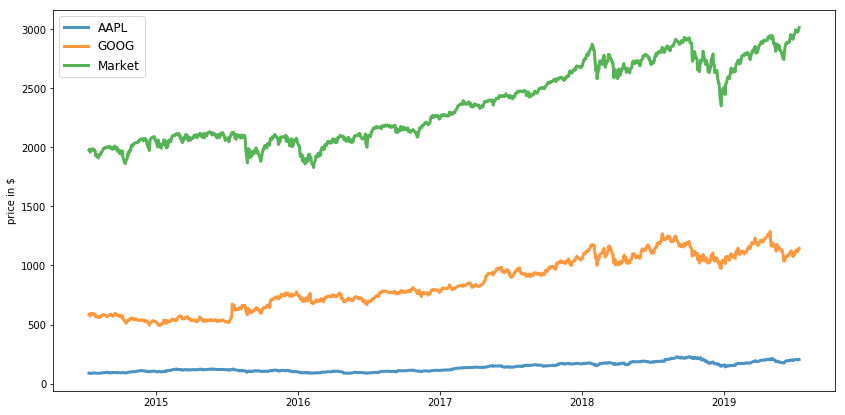

In [9]:
plt.figure(figsize=(14, 7))
for c in prices.columns.values:
    plt.plot(prices.index, prices[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

In [10]:
returns = prices.pct_change()
returns.dropna(inplace=True)
#returns = returns*100
returns.head()

,AAPL,GOOG,Market
Date,,,
2014-07-15,-0.011716,-0.000154,-0.001932
2014-07-16,-0.005665,-0.003625,0.004201
2014-07-17,-0.017831,-0.015326,-0.011834
2014-07-18,0.014395,0.037213,0.010265
2014-07-21,-0.005189,-0.009427,-0.002320


Text(0, 0.5, 'daily returns')

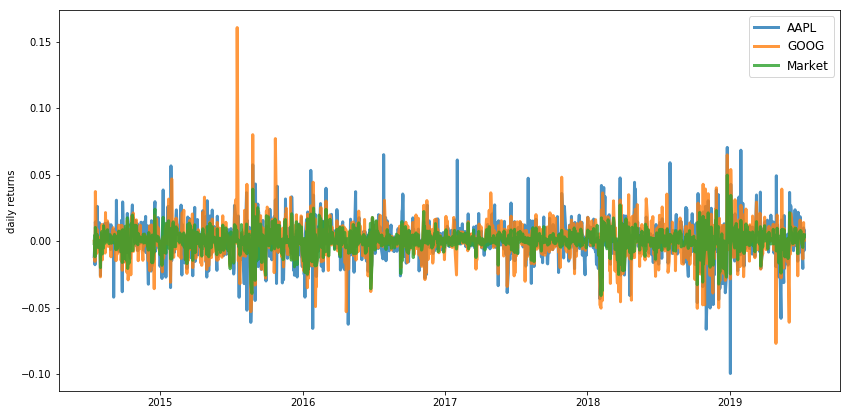

In [11]:
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [12]:
T = returns.index.size
N = len(keylist) - 1

In [13]:
drop_window = 252 # Drop first 252 days to match the benchmark with Markowitz starting data

# Benchmark 1

In [14]:
# Benchmark 1: 1/N of booksize in each stock at t=0, and do nothing afterwards.
Benchmark1 = returns.iloc[drop_window+1:,].copy()
w0 = 1/N
Benchmark1.head()

,AAPL,GOOG,Market
Date,,,
2015-07-16,0.013326,0.035040,0.008015
2015-07-17,0.008637,0.160524,0.001106
2015-07-20,0.018902,-0.014727,0.000771
2015-07-21,-0.009995,-0.001086,-0.004262
2015-07-22,-0.042294,-0.000302,-0.002388


In [15]:
for i in range(N):
    Benchmark1[Benchmark1.columns[i]+' Cum return'] =0

Benchmark1['Daily return'] = 0
Benchmark1['Cum return'] = 0

for i in range(N):
    Benchmark1[Benchmark1.columns[i]+' Cum return'] = (1+Benchmark1.iloc[:,i]).cumprod()

for i in range(N):
    Benchmark1['Cum return'] += w0*Benchmark1[Benchmark1.columns[i]+' Cum return']

Benchmark1['Daily return'] = Benchmark1['Cum return'].pct_change()
Benchmark1['Daily return'][0] = Benchmark1['Cum return'][0] - 1
Benchmark1.tail(5)

,AAPL,GOOG,Market,AAPL Cum return,GOOG Cum return,Daily return,Cum return
Date,,,,,,,
2019-07-08,-0.020614,-0.013468,-0.004835,1.691168,1.992699,-0.016761,1.841934
2019-07-09,0.006099,0.007596,0.001237,1.701483,2.007836,0.006909,1.854660
2019-07-10,0.009889,0.013913,0.004511,1.718308,2.035772,0.012067,1.877040
2019-07-11,-0.007282,0.003271,0.002285,1.705795,2.042430,-0.001560,1.874112
2019-07-12,0.007683,0.000603,0.004620,1.718900,2.043662,0.003825,1.881281


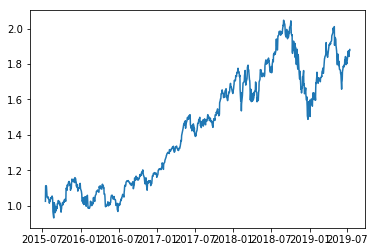

In [16]:
plt.plot(Benchmark1['Cum return'])

In [17]:
Benchmark1.to_csv('Benchmark1.csv')

# Benchmark 2

In [18]:
# Benchmark 2: 1/N of total portfolio value in each stock, and rebalance daily
w0 = 1/N
Benchmark2 = returns.iloc[drop_window+1:,].copy()
Benchmark2['Daily return'] = 0
for i in range(N):
    #print (Benchmark2.columns[i])
    Benchmark2['Daily return'] += w0*Benchmark2.iloc[:,i]
Benchmark2['Cum return'] = (1+Benchmark2['Daily return']).cumprod()
Benchmark2.tail(5)

,AAPL,GOOG,Market,Daily return,Cum return
Date,,,,,
2019-07-08,-0.020614,-0.013468,-0.004835,-0.017041,1.888108
2019-07-09,0.006099,0.007596,0.001237,0.006848,1.901037
2019-07-10,0.009889,0.013913,0.004511,0.011901,1.923661
2019-07-11,-0.007282,0.003271,0.002285,-0.002006,1.919802
2019-07-12,0.007683,0.000603,0.004620,0.004143,1.927756


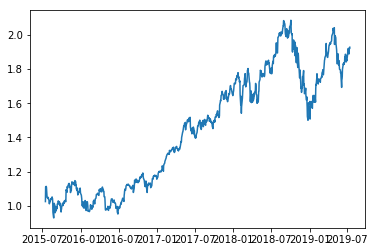

In [19]:
plt.plot(Benchmark2['Cum return'])

In [20]:
Benchmark2.to_csv('Benchmark2.csv')

# Markowitz

In [21]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) #252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) #* np.sqrt(252)
    return std, returns

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return (-(p_ret - risk_free_rate) / p_var)

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-1.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def exp_smoothing(returns, alpha):
    period = len(returns)
    exp_return = returns[0]
    if (period > 1):
        for i in range(1,period):
            exp_return = alpha * returns[i] + (1-alpha) * exp_return
    
    return (exp_return)

In [22]:
alpha = 0.9

In [23]:
# Markowitz Portolio Optimization
markowitz = returns.copy()
rf = 0#(1+0.01)**(1/365)-1
train_window = 252
for i in range(N):
    markowitz[markowitz.columns[i]+' Weight'] = 0

markowitz.head(5)

,AAPL,GOOG,Market,AAPL Weight,GOOG Weight
Date,,,,,
2014-07-15,-0.011716,-0.000154,-0.001932,0,0
2014-07-16,-0.005665,-0.003625,0.004201,0,0
2014-07-17,-0.017831,-0.015326,-0.011834,0,0
2014-07-18,0.014395,0.037213,0.010265,0,0
2014-07-21,-0.005189,-0.009427,-0.002320,0,0


In [24]:
start_time = time.process_time()

In [25]:
# Rolling train and test data
# Use 1 yr data to allocate weight for next day
# Use one-year exp smoothing return to estimate future one-day return, smoothing alpha=0.9
# Use last 1-yr sd to estimate future one-day sd
# 180 seconds for 4-year daily rolling

#t = T-train_window-2
#for t in range(100):
for t in range(T-train_window-1):
    train_index = markowitz.index[t:t+train_window]
    train_data = markowitz.loc[train_index,keylist[0:N]]
    mean_returns = train_data.apply(func=exp_smoothing,axis=0,alpha=alpha)#train_data.mean()
    cov_matrix = train_data.cov()

    for i in range(N):
        markowitz.loc[markowitz.index[t+train_window+1],markowitz.columns[i]+' Weight'] = max_sharpe_ratio(mean_returns, cov_matrix, rf).x[i]


        

In [26]:
end_time = time.process_time()
print (end_time-start_time)

47.92658


In [27]:
markowitz = markowitz.iloc[drop_window+1:,].copy()
markowitz['Daily return'] = 0
for i in range(N):
    markowitz['Daily return'] += markowitz.iloc[:,i]*markowitz.loc[:,markowitz.columns[i]+' Weight']

In [28]:
markowitz['Cum return'] = (1+markowitz['Daily return']).cumprod()

In [29]:
markowitz.tail(5)

,AAPL,GOOG,Market,AAPL Weight,GOOG Weight,Daily return,Cum return
Date,,,,,,,
2019-07-08,-0.020614,-0.013468,-0.004835,1.401559e-01,0.859844,-0.014469,1.503048
2019-07-09,0.006099,0.007596,0.001237,-1.387779e-16,1.000000,0.007596,1.514466
2019-07-10,0.009889,0.013913,0.004511,3.885781e-16,1.000000,0.013913,1.535537
2019-07-11,-0.007282,0.003271,0.002285,5.204170e-17,1.000000,0.003271,1.540559
2019-07-12,0.007683,0.000603,0.004620,5.551115e-17,1.000000,0.000603,1.541488


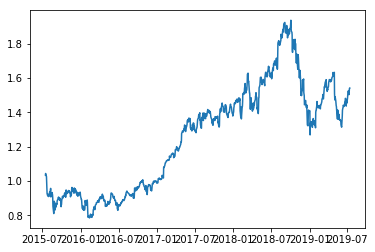

In [30]:
plt.plot(markowitz['Cum return'])

In [31]:
markowitz.to_csv('markowitz.csv')

Text(0.5, 1.0, 'Portfolio Allocation Strtegies Comparision')

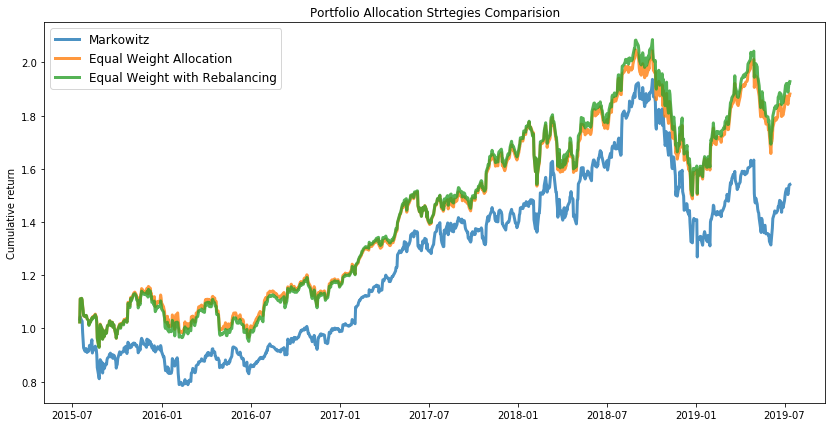

In [32]:
plt.figure(figsize=(14, 7))
plt.plot(markowitz['Cum return'].index, markowitz['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Benchmark1['Cum return'].index, Benchmark1['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Benchmark2['Cum return'].index, Benchmark2['Cum return'], lw=3, alpha=0.8,label=c)
plt.legend(labels = ('Markowitz', 'Equal Weight Allocation', 'Equal Weight with Rebalancing'), loc='upper left', fontsize=12)
plt.ylabel('Cumulative return')
plt.title('Portfolio Allocation Strtegies Comparision')

# Q-learning

In [34]:
import random

In [35]:
Q_returns = returns.copy().iloc[:,0:2]#.tail(100)

for i in keylist[0:N]:
    Q_returns[i+' pred'] = 0

pred_window = train_window

Q_T = len(Q_returns.index) - pred_window
Q_N = len(Q_returns.columns) - N

for t in range(Q_T-1):
    pred_index = Q_returns.index[t:t+train_window]
    pred_data = Q_returns.loc[pred_index,keylist[0:N]]
    mean_returns = pred_data.apply(func=exp_smoothing,axis=0,alpha=alpha)
    
    for i in range(Q_N):
        Q_returns.iloc[t + pred_window, i + Q_N] = mean_returns[i]

In [36]:
Q_returns_savetime = Q_returns.copy()
Q_returns_savetime.tail()

,AAPL,GOOG,AAPL pred,GOOG pred
Date,,,,
2019-07-08,-0.020614,-0.013468,0.000022,0.008993
2019-07-09,0.006099,0.007596,-0.018550,-0.011222
2019-07-10,0.009889,0.013913,0.003634,0.005714
2019-07-11,-0.007282,0.003271,0.009263,0.013093
2019-07-12,0.007683,0.000603,0.000000,0.000000


In [37]:
Q_returns = Q_returns_savetime.copy()

In [38]:
Q_returns = Q_returns_savetime[pred_window:]
Q_returns.head()

,AAPL,GOOG,AAPL pred,GOOG pred
Date,,,,
2015-07-15,0.009633,-0.001568,0.001599,0.026916
2015-07-16,0.013326,0.035040,0.008830,0.001280
2015-07-17,0.008637,0.160524,0.012876,0.031664
2015-07-20,0.018902,-0.014727,0.009061,0.147638
2015-07-21,-0.009995,-0.001086,0.017918,0.001510


In [39]:
Q_states = Q_returns.copy().iloc[:,N:2*N]
threthold = 0.0

for i in range(Q_T):
    for j in range (Q_N):
        if (Q_returns.iloc[i,j+N] <= -threthold):
            Q_states.iloc[i,j] = -1
        elif (Q_returns.iloc[i,j+N] > threthold):
            Q_states.iloc[i,j] = 1
        else:
            pass

Q_states['states'] = Q_states[Q_states.columns].apply(tuple, axis=1)
Q_states.head()

,AAPL pred,GOOG pred,states
Date,,,
2015-07-15,1.0,1.0,"(1.0, 1.0)"
2015-07-16,1.0,1.0,"(1.0, 1.0)"
2015-07-17,1.0,1.0,"(1.0, 1.0)"
2015-07-20,1.0,1.0,"(1.0, 1.0)"
2015-07-21,1.0,1.0,"(1.0, 1.0)"


In [40]:
state_space = [(-1,-1),(-1,1),(1,-1),(1,1)] #[(-1,-1),(-1,0),(-1,1),(0,-1),(0,0),(0,1),(1,-1),(1,0),(1,1)]
action_space = [0.3,0.5,0.7]#[0.1,0,-0.1,] #[0.2,0.1,0,-0.1,-0.2]
#action_space = [0.2,0.15,0.1,0.05,0,-0.05,-0.1,-0.15,-0.2]

state_size = len(state_space)
action_size = len(action_space)

lr = 0.1
w0 = [0.5]*Q_T
w1 = [0.5]*Q_T
gamma = 1

# Initialize q-table values to 0
Q = np.zeros((state_size, action_size))

In [41]:
start_time = time.clock()

/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [42]:
# Set the percent you want to explore
epsilon = 0.05
Q_previous = 0
Q_current = 1000

lambd = 1

#while (abs(Q_previous-Q_current)>100):
for loop in range(1000):
    Q_previous = Q.sum()
    
    for t in range(1,Q_T-1):

        for i in range(state_size):
            if Q_states.iloc[t,Q_N] == state_space[i]:
                state = i
            if Q_states.iloc[t+1,Q_N] == state_space[i]:
                new_state = i

        if random.uniform(0, 1) < epsilon:
            """
            Explore: select a random action
            """
            action = random.randint(0,action_size-1)
        else:
            """
            Exploit: select the action with max value (future reward)
            """
            action = np.argmax(Q[state, :])

        #w0[t] = w0[t-1] + action_space[action]
        #w1[t] = w1[t-1] - action_space[action]
        w0[t] = action_space[action]
        w1[t] = 1 - action_space[action]
        # Update q values
        
        #maximize return
        #reward = w0[t]*Q_returns.iloc[t+1,0+N] + w1[t]*Q_returns.iloc[t+1,1+N]
        
        #maximize return with penalty on large allocation on one stock
        #reward = w0[t]*Q_returns.iloc[t+1,0+N] + w1[t]*Q_returns.iloc[t+1,1+N] - lambd * (w0[t]**2+w1[t]**2)
        if (abs(w0[t])>1 or abs(w1[t])>1):
            penalty = 1
        else:
            penalty = 0
        reward = w0[t]*Q_returns.iloc[t+1,0+N] + w1[t]*Q_returns.iloc[t+1,1+N] - lambd * penalty
        
        Q[state, action] = Q[state, action] + lr * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])

    Q_current = Q.sum()

In [43]:
end_time = time.clock()
print ((end_time-start_time)/60)

2.0287698166666663


/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [44]:
Q

array([[14.56151231, 14.55840244, 14.58671013],
       [14.53035671, 14.54295923, 14.58251504],
       [14.58502708, 14.54470895, 14.52195631],
       [14.59185133, 14.56317824, 14.57109546]])

In [45]:
for i in range(1,T):
    state = Q_states.iloc[t,Q_N]
    for j in range(len(state_space)):
        if state_space[j] == state:
            state_index = j
    w0[t] = action_space[np.argmax(Q[state_index, :])]
    w1[t] = 1-action_space[np.argmax(Q[state_index, :])]

In [46]:
w0 = [0.5]+w0[0:Q_T-1]
w1 = [0.5]+w1[0:Q_T-1]

In [47]:
Q_returns['w0'] = w0
Q_returns['w1'] = w1
Q_returns = Q_returns[1:Q_T]

/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [48]:
Q_returns.tail(5)

,AAPL,GOOG,AAPL pred,GOOG pred,w0,w1
Date,,,,,,
2019-07-08,-0.020614,-0.013468,0.000022,0.008993,0.3,0.7
2019-07-09,0.006099,0.007596,-0.018550,-0.011222,0.5,0.5
2019-07-10,0.009889,0.013913,0.003634,0.005714,0.7,0.3
2019-07-11,-0.007282,0.003271,0.009263,0.013093,0.3,0.7
2019-07-12,0.007683,0.000603,0.000000,0.000000,0.3,0.7


In [49]:
Q_returns['Daily return'] = 0
for i in range(Q_N):
    Q_returns['Daily return'] += Q_returns.iloc[:,i] * Q_returns.iloc[:,i+Q_N*2]
#Q_returns['Daily return'] = Q_returns.iloc[:,0] * 0.5+Q_returns.iloc[:,1] * 0.5

In [50]:
Q_returns['Cum return'] = (1+Q_returns['Daily return']).cumprod()

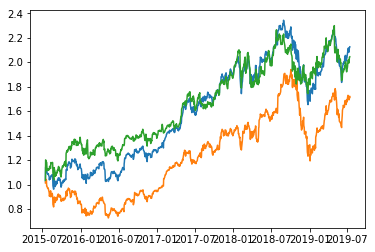

In [51]:
plt.plot(Q_returns['Cum return'])
plt.plot((1+Q_returns['AAPL']).cumprod())
plt.plot((1+Q_returns['GOOG']).cumprod())

In [52]:
Q_returns.tail()

,AAPL,GOOG,AAPL pred,GOOG pred,w0,w1,Daily return,Cum return
Date,,,,,,,,
2019-07-08,-0.020614,-0.013468,0.000022,0.008993,0.3,0.7,-0.015612,2.081427
2019-07-09,0.006099,0.007596,-0.018550,-0.011222,0.5,0.5,0.006848,2.095680
2019-07-10,0.009889,0.013913,0.003634,0.005714,0.7,0.3,0.011096,2.118934
2019-07-11,-0.007282,0.003271,0.009263,0.013093,0.3,0.7,0.000105,2.119156
2019-07-12,0.007683,0.000603,0.000000,0.000000,0.3,0.7,0.002727,2.124935


In [53]:
Q_returns.to_csv('Q_returns.csv')

Text(0.5, 1.0, 'Portfolio Allocation Strtegies Comparision')

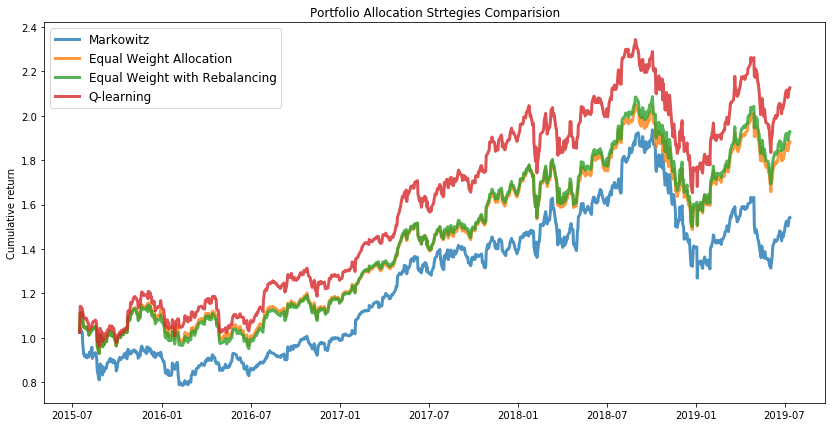

In [54]:
plt.figure(figsize=(14, 7))
plt.plot(markowitz['Cum return'].index, markowitz['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Benchmark1['Cum return'].index, Benchmark1['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Benchmark2['Cum return'].index, Benchmark2['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Q_returns['Cum return'].index, Q_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.legend(labels = ('Markowitz', 'Equal Weight Allocation', 'Equal Weight with Rebalancing', 'Q-learning'), loc='upper left', fontsize=12)
plt.ylabel('Cumulative return')
plt.title('Portfolio Allocation Strtegies Comparision')

# G-learning

In [55]:
G_T = Q_T
G_N = Q_N

G_states = Q_states.copy()
G_returns = Q_returns_savetime.copy()[pred_window:]

# Initialize q-table values to 0
G = 0*np.ones((state_size, action_size))

# Prior policy
p_action = [1/len(action_space)]*len(action_space)

In [56]:
start_time = time.clock()

/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [57]:
# Set the percent you want to explore
epsilon = 0.05
G_previous = 0
G_current = 100

beta = 0.01 

k = 1

for loop in range(1000):
#while (abs(G_previous-G_current)>10**(0)):
    
    k += 1
    beta = 0.001*k
    
    G_previous = G.sum()
    
    for t in range(1,G_T-1):

        for i in range(state_size):
            if G_states.iloc[t,G_N] == state_space[i]:
                state = i
            if G_states.iloc[t+1,G_N] == state_space[i]:
                new_state = i

        if random.uniform(0, 1) < epsilon:
            """
            Explore: select a random action
            """
            action = random.randint(0,action_size-1)
        else:
            """
            Exploit: select the action with min value (future reward)
            """
            action = np.argmin(G[state, :])

        #w0[t] = w0[t-1] + action_space[action]
        #w1[t] = w1[t-1] - action_space[action]
        w0[t] = action_space[action]
        w1[t] = 1 - action_space[action]
        
        # Update G values
        # minimize cost with penalty
        
        #print (G[state, action], np.log(np.dot(np.array([p_action]),np.exp(-beta*np.array([G[new_state,:]]).T))))
        
        reward = -(w0[t]*G_returns.iloc[t+1,0] + w1[t]*G_returns.iloc[t+1,1]) 
        
        G[state, action] = (1 - lr) * G[state, action] + lr * (reward - gamma / beta * np.log(np.dot(np.array([p_action]),np.exp(-beta*np.array([G[new_state,:]]).T))))    
        
    G_current = G.sum()

In [58]:
end_time = time.clock()
print ((end_time-start_time)/60)

2.383035783333333


/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [59]:
beta

1.0010000000000001

In [60]:
G

array([[13.33610935, 13.33941891, 13.33977286],
       [13.33619983, 13.33870025, 13.33861853],
       [13.33962576, 13.33305004, 13.33755375],
       [13.34129324, 13.33731735, 13.33939465]])

In [61]:
for i in range(1,T):
    state = G_states.iloc[t,G_N]
    for j in range(len(state_space)):
        if state_space[j] == state:
            state_index = j
    w0[t] = action_space[np.argmin(G[state_index, :])]
    w1[t] = 1-action_space[np.argmin(G[state_index, :])]

w0 = [0.5]+w0[0:G_T-1]
w1 = [0.5]+w1[0:G_T-1]

G_returns['w0'] = w0
G_returns['w1'] = w1
G_returns = G_returns[1:G_T]

In [62]:
G_returns['Daily return'] = 0
for i in range(G_N):
    G_returns['Daily return'] += G_returns.iloc[:,i] * G_returns.iloc[:,i+G_N*2]

In [63]:
G_returns['Cum return'] = (1+G_returns['Daily return']).cumprod()

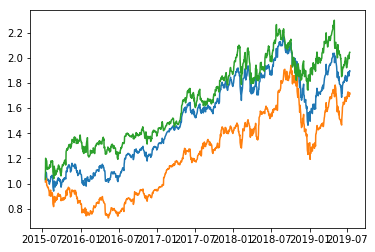

In [64]:
plt.plot(G_returns['Cum return'])
plt.plot((1+G_returns['AAPL']).cumprod())
plt.plot((1+G_returns['GOOG']).cumprod())

In [65]:
G_returns.tail()

,AAPL,GOOG,AAPL pred,GOOG pred,w0,w1,Daily return,Cum return
Date,,,,,,,,
2019-07-08,-0.020614,-0.013468,0.000022,0.008993,0.5,0.5,-0.017041,1.855252
2019-07-09,0.006099,0.007596,-0.018550,-0.011222,0.5,0.5,0.006848,1.867957
2019-07-10,0.009889,0.013913,0.003634,0.005714,0.3,0.7,0.012706,1.891691
2019-07-11,-0.007282,0.003271,0.009263,0.013093,0.5,0.5,-0.002006,1.887896
2019-07-12,0.007683,0.000603,0.000000,0.000000,0.5,0.5,0.004143,1.895717


In [66]:
G_returns.to_csv('G_returns.csv')

Text(0.5, 1.0, 'Portfolio Allocation Strtegies Comparision')

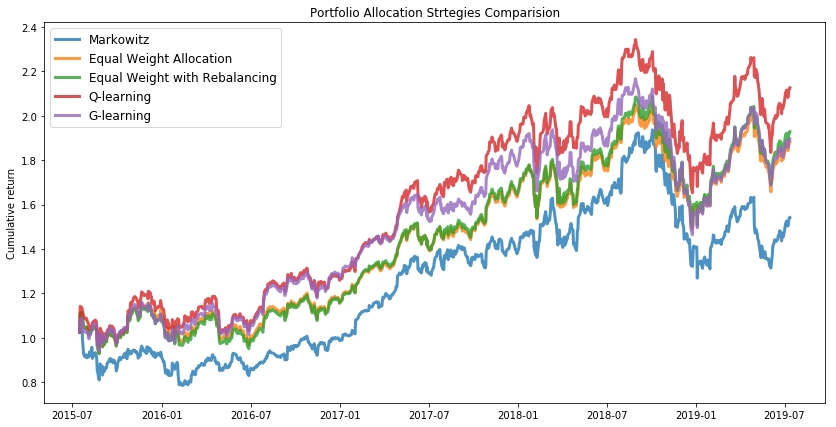

In [67]:
plt.figure(figsize=(14, 7))
plt.plot(markowitz['Cum return'].index, markowitz['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Benchmark1['Cum return'].index, Benchmark1['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Benchmark2['Cum return'].index, Benchmark2['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Q_returns['Cum return'].index, Q_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(G_returns['Cum return'].index, G_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.legend(labels = ('Markowitz', 'Equal Weight Allocation', 'Equal Weight with Rebalancing', 
                     'Q-learning', 'G-learning'), loc='upper left', fontsize=12)
plt.ylabel('Cumulative return')
plt.title('Portfolio Allocation Strtegies Comparision')

# DQN

In [68]:
from enums import *
import tensorflow as tf

In [69]:
DQN_states = Q_states.copy()
DQN_returns = Q_returns_savetime.copy()[pred_window:]

In [70]:
DQN_states.tail()

,AAPL pred,GOOG pred,states
Date,,,
2019-07-08,1.0,1.0,"(1.0, 1.0)"
2019-07-09,-1.0,-1.0,"(-1.0, -1.0)"
2019-07-10,1.0,1.0,"(1.0, 1.0)"
2019-07-11,1.0,1.0,"(1.0, 1.0)"
2019-07-12,-1.0,-1.0,"(-1.0, -1.0)"


In [71]:
class DQN:
    def __init__(self, DQN_returns, DQN_states, action_space, state_space, update_freq = 30, learning_rate=0.1, discount=1, exploration_rate=0.05, iterations=100):
        self.learning_rate = learning_rate
        self.discount = discount # How much we appreciate future reward over current
        self.exploration_rate = 1.0 # Initial exploration rate
        self.exploration_delta = 1.0 / iterations # Shift from exploration to exploitation
        
        # Input has 4 neurons, each represents a state ((-1,-1),(-1,1),etc.)
        self.input_count = len(state_space)
        # Output is 2 neurons, each represents Q-value for action ([0.3,0.5,0.7])
        self.output_count = len(action_space)

        self.session = tf.Session()
        self.define_model()
        self.session.run(self.initializer)
        
        self.returns = DQN_returns
        self.states_pred = DQN_states
        self.action_space = action_space
        self.state_space = state_space
        self.N = len(DQN_states.columns)-1
        self.T = len(DQN_returns.index)
        self.iterations = iterations
        self.experience = []
        self.update_freq = update_freq
        
        self.targetQ = {}
        for state in self.state_space: 
            self.targetQ.update({state:self.get_Q(state)})
        
    # Define tensorflow model graph
    def define_model(self):
        # Input is an array of 4 items (state one-hot)
        # Input is 2-dimensional, due to possibility of batched training data
        # NOTE: In this example we assume no batching.
        self.model_input = tf.placeholder(dtype=tf.float32, shape=[None, self.input_count])

        # Two hidden layers of 16 neurons with sigmoid activation initialized to zero for stability
        fc1 = tf.layers.dense(self.model_input, 16, activation=tf.sigmoid, kernel_initializer=tf.constant_initializer(np.zeros((self.input_count, 16))))
        fc2 = tf.layers.dense(fc1, 16, activation=tf.sigmoid, kernel_initializer=tf.constant_initializer(np.zeros((16, self.output_count))))

        # Output is two values, Q for both possible actions FORWARD and BACKWARD
        # Output is 2-dimensional, due to possibility of batched training data
        # NOTE: In this example we assume no batching.
        self.model_output = tf.layers.dense(fc2, self.output_count)

        # This is for feeding training output (a.k.a ideal target values)
        self.target_output = tf.placeholder(shape=[None, self.output_count], dtype=tf.float32)
        # Loss is mean squared difference between current output and ideal target values
        loss = tf.losses.mean_squared_error(self.target_output, self.model_output)
        # Optimizer adjusts weights to minimize loss, with the speed of learning_rate
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).minimize(loss)
        # Initializer to set weights to initial values
        self.initializer = tf.global_variables_initializer()

    # Ask model to estimate Q value for specific state (inference)
    def get_Q(self, state):
        # Model input: Single state represented by array of 4 items (state one-hot)
        # Model output: Array of Q values for single state
        return self.session.run(self.model_output, feed_dict={self.model_input: self.to_one_hot(state)})[0]

    # Turn state into 2d one-hot tensor
    # Example: 3 -> [[0,0,0,1,0]]
    
    def get_state_index(self, state):
        state_index = 0
        for i in range(self.output_count):
            if self.state_space[i] == state:
                state_index = i
        return state_index
    
    def to_one_hot(self, state):
        state_index = self.get_state_index(state)
        one_hot = np.zeros((1, self.input_count))
        one_hot[0, [state_index]] = 1
        return one_hot
    
    def get_next_action(self, state):
        if random.random() > self.exploration_rate: # Explore (gamble) or exploit (greedy)
            return self.greedy_action(state)
        else:
            return self.random_action()

    # Which action has bigger Q-value, estimated by our model (inference).
    def greedy_action(self, state):
        # argmax picks the higher Q-value and returns the index
        return np.argmax(self.get_Q(state))

    def random_action(self):
        return (random.randint(0,self.output_count-1))
    
    def get_reward(self, action, t):
        w0 = self.action_space[action]
        w1 = 1 - w0
        reward = w0*self.returns.iloc[t+1,0+self.N] + w1*self.returns.iloc[t+1,1+self.N]
        return (reward)
    
    def train_single_experience(self):
        '''
        Repeat for a batch:
            Get Q for old state and new state from the old NNet
            Store Experience
            Update Q by Q-learning update
            Sample Experience
        Update the NNet by the updated Q-value
        '''
        for t in range(1,self.T-1):

            # Get old and new states
            old_state = self.states_pred.iloc[t,self.N]
            new_state = self.states_pred.iloc[t+1,self.N]
            
            # Ask the model for the Q values of the old state (inference)
            old_state_Q_values = self.get_Q(old_state)
            # Ask the model for the Q values of the new state (inference)
            new_state_Q_values = self.get_Q(new_state)

            # Get action
            action = self.get_next_action(old_state)

            # Real Q value for the action we took. This is what we will train towards.
            reward = self.get_reward(action, t)
            old_state_Q_values[action] = reward + self.discount * np.amax(new_state_Q_values)

            # Setup training data
            training_input = self.to_one_hot(old_state)
            target_output = [old_state_Q_values]
            training_data = {self.model_input: training_input, self.target_output: target_output}

            # Train
            self.session.run(self.optimizer, feed_dict=training_data)
    
    def update_targetQ(self):
        for state in self.state_space:
            self.targetQ[state] = self.get_Q(state)
    
    def train_experience_reply(self):
        '''
        Get Q for old state and new state from the old NNet
        Update Q by Q-learning update
        Update the NNet by the updated Q-value
        '''
        for t in range(0,self.T-1):
            
            # Get old and new states
            old_state = self.states_pred.iloc[t,self.N]
            new_state = self.states_pred.iloc[t+1,self.N]
            
            # Ask the model for the Q values of the old state (inference)
            old_state_Q_values = self.get_Q(old_state)
            # Ask the model for the Q values of the new state (inference)
            new_state_Q_values = self.targetQ[new_state]

            # Get action
            action = self.get_next_action(old_state)

            # Get reward
            reward = self.get_reward(action, t)
            
            # Store experience (old_state,action,reward,new_state)
            self.experience.append([old_state,action,reward,new_state])
            
            # Get an experience from memory randomly
            single_experience = random.choice(self.experience)
            old_state = single_experience[0]
            new_state = single_experience[3]
            action = single_experience[1]
            reward = single_experience[2]
            
            # Update Q
            old_state_Q_values[action] = reward + self.discount * np.amax(new_state_Q_values)
            
            # Setup training data
            training_input = self.to_one_hot(old_state)
            target_output = [old_state_Q_values]
            training_data = {self.model_input: training_input, self.target_output: target_output}

            # Train
            self.session.run(self.optimizer, feed_dict=training_data)
            
            # Update target every C steps
            if (t % self.update_freq == 0):
                self.update_targetQ()
            
    def update_single_experience(self):
        # Train our model with new data
        for i in range (self.iterations):
            self.train_single_experience()
        
    def update_single_experience_shift_exploration(self):
        # Train our model with new data
        for i in range (self.iterations):
            self.train_single_experience()

            # Finally shift our exploration_rate toward zero (less gambling)
            if self.exploration_rate > 0:
                   self.exploration_rate -= self.exploration_delta
                    
    def update_experience_reply(self):
        # Train our model with new data
        for i in range (self.iterations):
            self.train_experience_reply()
        
    def update_experience_reply_shift_exploration(self):
        # Train our model with new data
        for i in range (self.iterations):
            self.train_experience_reply()

            # Finally shift our exploration_rate toward zero (less gambling)
            if self.exploration_rate > 0:
                   self.exploration_rate -= self.exploration_delta

In [72]:
Deep_Q = DQN(DQN_returns, DQN_states, action_space, state_space)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [73]:
Deep_Q.targetQ

{(-1, -1): array([-0.2698696,  0.0330044,  1.1796395], dtype=float32),
 (-1, 1): array([-0.2698696,  0.0330044,  1.1796395], dtype=float32),
 (1, -1): array([-0.2698696,  0.0330044,  1.1796395], dtype=float32),
 (1, 1): array([-0.2698696,  0.0330044,  1.1796395], dtype=float32)}

In [74]:
start_time = time.clock()

/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [75]:
Deep_Q.update_experience_reply()

In [76]:
end_time = time.clock()
print (-start_time + end_time)

287.47497000000004


/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [77]:
Deep_Q.get_Q(state)

array([32.02586 , 32.049965, 32.047256], dtype=float32)

In [78]:
for i in range(1,Deep_Q.T):
    state = DQN_states.iloc[t,Deep_Q.N]
    w0[t] = action_space[np.argmax(Deep_Q.get_Q(state))]
    w1[t] = 1-w0[t]

w0 = [0.5]+w0[0:Deep_Q.T-1]
w1 = [0.5]+w1[0:Deep_Q.T-1]

DQN_returns['w0'] = w0
DQN_returns['w1'] = w1
DQN_returns = DQN_returns[1:Deep_Q.T]

In [79]:
DQN_returns['Daily return'] = 0
for i in range(G_N):
    DQN_returns['Daily return'] += DQN_returns.iloc[:,i] * DQN_returns.iloc[:,i+G_N*2]

/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
DQN_returns['Cum return'] = (1+DQN_returns['Daily return']).cumprod()

/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


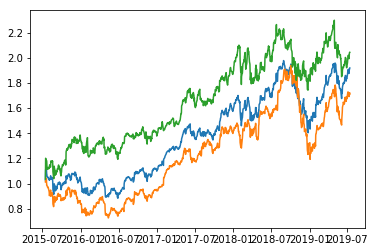

In [81]:
plt.plot(DQN_returns['Cum return'])
plt.plot((1+DQN_returns['AAPL']).cumprod())
plt.plot((1+DQN_returns['GOOG']).cumprod())

In [82]:
DQN_returns.tail()

,AAPL,GOOG,AAPL pred,GOOG pred,w0,w1,Daily return,Cum return
Date,,,,,,,,
2019-07-08,-0.020614,-0.013468,0.000022,0.008993,0.5,0.5,-0.017041,1.875338
2019-07-09,0.006099,0.007596,-0.018550,-0.011222,0.5,0.5,0.006848,1.888180
2019-07-10,0.009889,0.013913,0.003634,0.005714,0.5,0.5,0.011901,1.910651
2019-07-11,-0.007282,0.003271,0.009263,0.013093,0.3,0.7,0.000105,1.910851
2019-07-12,0.007683,0.000603,0.000000,0.000000,0.5,0.5,0.004143,1.918768


In [83]:
DQN_returns.to_csv('DQN_returns.csv')

Text(0.5, 1.0, 'Portfolio Allocation Strtegies Comparision')

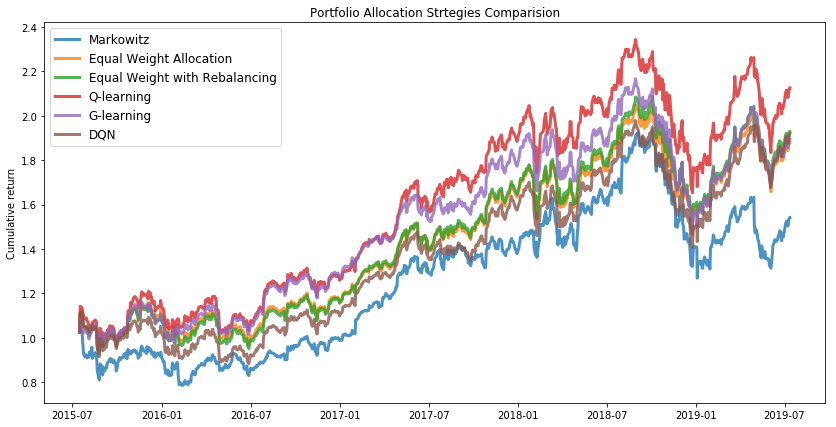

In [84]:
plt.figure(figsize=(14, 7))
plt.plot(markowitz['Cum return'].index, markowitz['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Benchmark1['Cum return'].index, Benchmark1['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Benchmark2['Cum return'].index, Benchmark2['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Q_returns['Cum return'].index, Q_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(G_returns['Cum return'].index, G_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(DQN_returns['Cum return'].index, DQN_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.legend(labels = ('Markowitz', 'Equal Weight Allocation', 'Equal Weight with Rebalancing', 
                     'Q-learning', 'G-learning', 'DQN'), loc='upper left', fontsize=12)
plt.ylabel('Cumulative return')
plt.title('Portfolio Allocation Strtegies Comparision')

# DGN

In [85]:
DGN_states = Q_states.copy()
DGN_returns = Q_returns_savetime.copy()[pred_window:]

# Prior policy
p_action = [1/len(action_space)]*len(action_space)

In [86]:
DGN_states.tail()

,AAPL pred,GOOG pred,states
Date,,,
2019-07-08,1.0,1.0,"(1.0, 1.0)"
2019-07-09,-1.0,-1.0,"(-1.0, -1.0)"
2019-07-10,1.0,1.0,"(1.0, 1.0)"
2019-07-11,1.0,1.0,"(1.0, 1.0)"
2019-07-12,-1.0,-1.0,"(-1.0, -1.0)"


In [87]:
# Learning rate = 1 now

class DGN:
    def __init__(self, prior, beta, beta_rate, DGN_returns, DGN_states, action_space, state_space, update_freq = 30, learning_rate=1, discount=1, exploration_rate=0.05, iterations=100):
        self.learning_rate = learning_rate
        self.discount = discount # How much we appreciate future reward over current
        self.exploration_rate = 1.0 # Initial exploration rate
        self.exploration_delta = 1.0 / iterations # Shift from exploration to exploitation

        # Input has 4 neurons, each represents a state ((-1,-1),(-1,1),etc.)
        self.input_count = len(state_space)
        # Output is 2 neurons, each represents G-value for action ([0.3,0.5,0.7])
        self.output_count = len(action_space)

        self.session = tf.Session()
        self.define_model()
        self.session.run(self.initializer)
        
        self.returns = DGN_returns
        self.states_pred = DGN_states
        self.action_space = action_space
        self.state_space = state_space
        self.N = len(DGN_states.columns)-1
        self.T = len(DGN_returns.index)
        self.iterations = iterations
        self.experience = []
        self.update_freq = update_freq
        self.prior = prior
        self.beta_rate = beta_rate
        self.beta = beta
        
        self.targetG = {}
        for state in self.state_space: 
            self.targetG.update({state:self.get_G(state)})
        
    # Define tensorflow model graph
    def define_model(self):
        # Input is an array of 4 items (state one-hot)
        # Input is 2-dimensional, due to possibility of batched training data
        # NOTE: In this example we assume no batching.
        self.model_input = tf.placeholder(dtype=tf.float32, shape=[None, self.input_count])

        # Two hidden layers of 16 neurons with sigmoid activation initialized to zero for stability
        fc1 = tf.layers.dense(self.model_input, 16, activation=tf.sigmoid, kernel_initializer=tf.constant_initializer(np.zeros((self.input_count, 16))))
        fc2 = tf.layers.dense(fc1, 16, activation=tf.sigmoid, kernel_initializer=tf.constant_initializer(np.zeros((16, self.output_count))))

        # Output is two values, G for both possible actions FORWARD and BACKWARD
        # Output is 2-dimensional, due to possibility of batched training data
        # NOTE: In this example we assume no batching.
        self.model_output = tf.layers.dense(fc2, self.output_count)

        # This is for feeding training output (a.k.a ideal target values)
        self.target_output = tf.placeholder(shape=[None, self.output_count], dtype=tf.float32)
        # Loss is mean squared difference between current output and ideal target values
        loss = tf.losses.mean_squared_error(self.target_output, self.model_output)
        # Optimizer adjusts weights to minimize loss, with the speed of learning_rate
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).minimize(loss)
        # Initializer to set weights to initial values
        self.initializer = tf.global_variables_initializer()

    # Ask model to estimate G value for specific state (inference)
    def get_G(self, state):
        # Model input: Single state represented by array of 4 items (state one-hot)
        # Model output: Array of G values for single state
        return self.session.run(self.model_output, feed_dict={self.model_input: self.to_one_hot(state)})[0]

    # Turn state into 2d one-hot tensor
    # Example: 3 -> [[0,0,0,1,0]]
    
    def get_state_index(self, state):
        state_index = 0
        for i in range(self.output_count):
            if self.state_space[i] == state:
                state_index = i
        return state_index
    
    def to_one_hot(self, state):
        state_index = self.get_state_index(state)
        one_hot = np.zeros((1, self.input_count))
        one_hot[0, [state_index]] = 1
        return one_hot
    
    def get_next_action(self, state):
        if random.random() > self.exploration_rate: # Explore (gamble) or exploit (greedy)
            return self.greedy_action(state)
        else:
            return self.random_action()

    # Which action has bigger G-value, estimated by our model (inference).
    def greedy_action(self, state):
        # argmin picks the higher G-value and returns the index
        return np.argmin(self.get_G(state))

    def random_action(self):
        return (random.randint(0,self.output_count-1))
    
    def get_reward(self, action, t):
        w0 = self.action_space[action]
        w1 = 1 - w0
        # Get negative reward, aka cost
        reward = -(w0*self.returns.iloc[t+1,0+self.N] + w1*self.returns.iloc[t+1,1+self.N])
        return (reward)
    
    def train_single_experience(self):
        
        for t in range(1,self.T-1):
            
            self.beta += self.beta_rate
            
            # Get old and new states
            old_state = self.states_pred.iloc[t,self.N]
            new_state = self.states_pred.iloc[t+1,self.N]
            
            # Ask the model for the G values of the old state (inference)
            old_state_G_values = self.get_G(old_state)
            # Ask the model for the G values of the new state (inference)
            new_state_G_values = self.get_G(new_state)

            # Get action
            action = self.get_next_action(old_state)

            # Real G value for the action we took. This is what we will train towards.
            reward = self.get_reward(action, t)           
            td = 0
            for i in range(self.output_count):
                td += self.prior[i]*np.exp(-self.beta*new_state_G_values[i])
            old_state_G_values[action] = (1 - self.learning_rate) * old_state_G_values[action] + self.learning_rate * (reward - self.discount / self.beta * np.log(td))    
        
            
            # Setup training data
            training_input = self.to_one_hot(old_state)
            target_output = [old_state_G_values]
            training_data = {self.model_input: training_input, self.target_output: target_output}

            # Train
            self.session.run(self.optimizer, feed_dict=training_data)
    
    def update_targetG(self):
        for state in self.state_space:
            self.targetG[state] = self.get_G(state)
    
    def train_experience_reply(self):

        for t in range(0,self.T-1):
            
            self.beta += self.beta_rate
            
            # Get old and new states
            old_state = self.states_pred.iloc[t,self.N]
            new_state = self.states_pred.iloc[t+1,self.N]
            
            # Ask the model for the G values of the old state (inference)
            old_state_G_values = self.get_G(old_state)
            # Ask the model for the G values of the new state (inference)
            new_state_G_values = self.targetG[new_state]

            # Get action
            action = self.get_next_action(old_state)

            # Get reward
            reward = self.get_reward(action, t)
            
            # Store experience (old_state,action,reward,new_state)
            self.experience.append([old_state,action,reward,new_state])
            
            # Get an experience from memory randomly
            single_experience = random.choice(self.experience)
            old_state = single_experience[0]
            new_state = single_experience[3]
            action = single_experience[1]
            reward = single_experience[2]
            
            # Update G
            old_state_G_values[action] = reward + self.discount * np.amin(new_state_G_values)            
            td = 0
            for i in range(self.output_count):
                td += self.prior[i]*np.exp(-self.beta*new_state_G_values[i])
            old_state_G_values[action] = (1 - self.learning_rate) * old_state_G_values[action] + self.learning_rate * (reward - self.discount / self.beta * np.log(td))    
        
            # Setup training data
            training_input = self.to_one_hot(old_state)
            target_output = [old_state_G_values]
            training_data = {self.model_input: training_input, self.target_output: target_output}

            # Train
            self.session.run(self.optimizer, feed_dict=training_data)
            
            # Update target every C steps
            if (t % self.update_freq == 0):
                self.update_targetG()
            
    def update_single_experience(self):
        # Train our model with new data
        for i in range (self.iterations):
            self.train_single_experience()

            # Finally shift our exploration_rate toward zero (less gambling)
            #if self.exploration_rate > 0:
            #    self.exploration_rate -= self.exploration_delta
        
    def update_single_experience_shift_exploration(self):
        # Train our model with new data
        for i in range (self.iterations):
            self.train_single_experience()

            # Finally shift our exploration_rate toward zero (less gambling)
            if self.exploration_rate > 0:
                   self.exploration_rate -= self.exploration_delta
                    
    def update_experience_reply(self):
        # Train our model with new data
        for i in range (self.iterations):
            self.train_experience_reply()

            # Finally shift our exploration_rate toward zero (less gambling)
            #if self.exploration_rate > 0:
            #    self.exploration_rate -= self.exploration_delta
        
    def update_experience_reply_shift_exploration(self):
        # Train our model with new data
        for i in range (self.iterations):
            self.train_experience_reply()

            # Finally shift our exploration_rate toward zero (less gambling)
            if self.exploration_rate > 0:
                   self.exploration_rate -= self.exploration_delta

In [88]:
beta_rate=0.00001
beta = 0
Deep_G = DGN(p_action, beta, beta_rate, DGN_returns, DGN_states, action_space, state_space)

In [89]:
start_time = time.clock()

/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [90]:
Deep_G.update_experience_reply()

In [91]:
end_time = time.clock()
print (-start_time + end_time)

284.368248


/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [92]:
Deep_G.beta

1.0049999999981165

In [93]:
Deep_G.get_G(state)

array([-2.3655956, -2.376169 , -2.3527815], dtype=float32)

In [94]:
for i in range(1,Deep_G.T):
    state = DGN_states.iloc[t,Deep_G.N]
    w0[t] = action_space[np.argmin(Deep_G.get_G(state))]
    w1[t] = 1-w0[t]

w0 = [0.5]+w0[0:Deep_G.T-1]
w1 = [0.5]+w1[0:Deep_G.T-1]

DGN_returns['w0'] = w0
DGN_returns['w1'] = w1
DGN_returns = DGN_returns[1:Deep_G.T]

In [95]:
DGN_returns['Daily return'] = 0
for i in range(G_N):
    DGN_returns['Daily return'] += DGN_returns.iloc[:,i] * DGN_returns.iloc[:,i+G_N*2]

/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [96]:
DGN_returns['Cum return'] = (1+DGN_returns['Daily return']).cumprod()

/Users/heshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


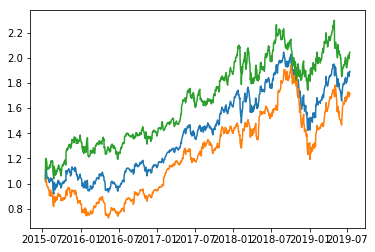

In [97]:
plt.plot(DGN_returns['Cum return'])
plt.plot((1+DGN_returns['AAPL']).cumprod())
plt.plot((1+DGN_returns['GOOG']).cumprod())

In [98]:
DGN_returns.tail()

,AAPL,GOOG,AAPL pred,GOOG pred,w0,w1,Daily return,Cum return
Date,,,,,,,,
2019-07-08,-0.020614,-0.013468,0.000022,0.008993,0.5,0.5,-0.017041,1.852130
2019-07-09,0.006099,0.007596,-0.018550,-0.011222,0.5,0.5,0.006848,1.864813
2019-07-10,0.009889,0.013913,0.003634,0.005714,0.5,0.5,0.011901,1.887006
2019-07-11,-0.007282,0.003271,0.009263,0.013093,0.5,0.5,-0.002006,1.883221
2019-07-12,0.007683,0.000603,0.000000,0.000000,0.5,0.5,0.004143,1.891023


In [99]:
DGN_returns.to_csv('DGN_returns.csv')

Text(0.5, 1.0, 'Portfolio Allocation Strtegies Comparision')

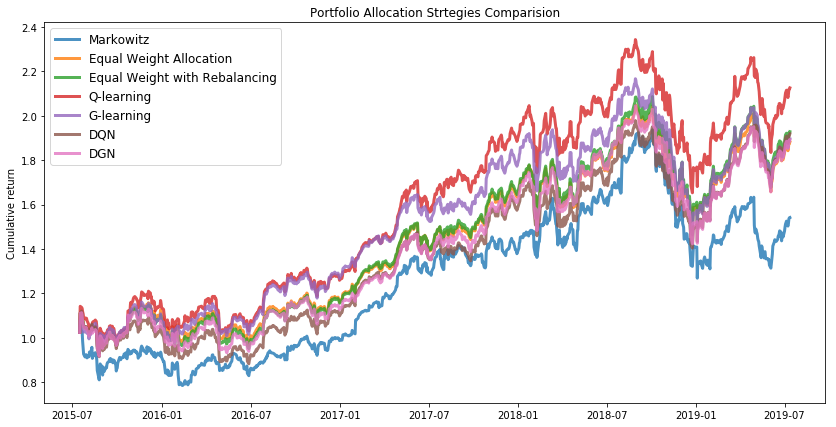

In [100]:
plt.figure(figsize=(14, 7))
plt.plot(markowitz['Cum return'].index, markowitz['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Benchmark1['Cum return'].index, Benchmark1['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Benchmark2['Cum return'].index, Benchmark2['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Q_returns['Cum return'].index, Q_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(G_returns['Cum return'].index, G_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(DQN_returns['Cum return'].index, DQN_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(DGN_returns['Cum return'].index, DGN_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.legend(labels = ('Markowitz', 'Equal Weight Allocation', 'Equal Weight with Rebalancing', 
                     'Q-learning', 'G-learning', 'DQN', 'DGN'), loc='upper left', fontsize=12)
plt.ylabel('Cumulative return')
plt.title('Portfolio Allocation Strtegies Comparision')

# Continuous G-learning

In [109]:
ContinuousG_returns = pd.read_csv('Continuous G-learning.csv', index_col='Date')
ContinuousG_returns.index = pd.to_datetime(ContinuousG_returns.index)
ContinuousG_returns.tail()

,AAPL,GOOG,w0,w1,risk-free asset weight,Daily return,Cum return
Date,,,,,,,
2019-07-08,-0.020614,-0.013468,0.846076,0.994553,0.111226,-0.030829,1.891681
2019-07-09,0.006099,0.007596,0.846049,1.003442,0.042190,0.012785,1.915866
2019-07-10,0.009889,0.013913,0.830308,0.992127,0.093430,0.022019,1.958052
2019-07-11,-0.007282,0.003271,0.833281,0.997743,0.127028,-0.002798,1.952573
2019-07-12,0.007683,0.000603,0.840955,1.010753,0.100866,0.007076,1.966389


Text(0.5, 1.0, 'Portfolio Allocation Strtegies Comparision')

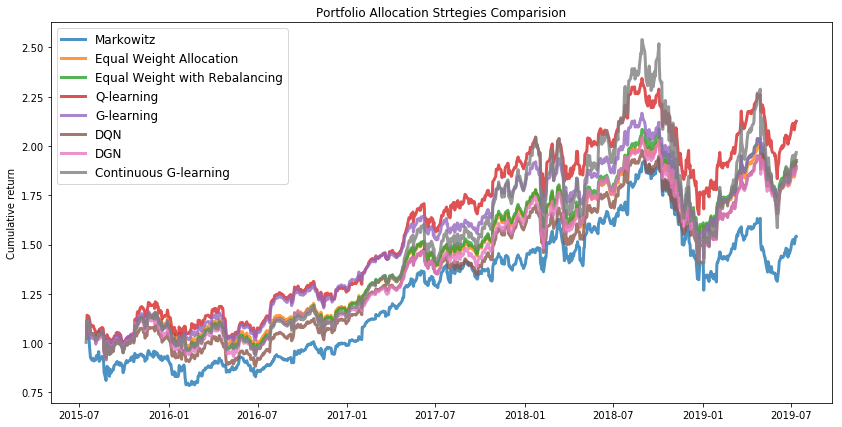

In [110]:
plt.figure(figsize=(14, 7))
plt.plot(markowitz['Cum return'].index, markowitz['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Benchmark1['Cum return'].index, Benchmark1['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Benchmark2['Cum return'].index, Benchmark2['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Q_returns['Cum return'].index, Q_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(G_returns['Cum return'].index, G_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(DQN_returns['Cum return'].index, DQN_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(DGN_returns['Cum return'].index, DGN_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(ContinuousG_returns['Cum return'].index, ContinuousG_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.legend(labels = ('Markowitz', 'Equal Weight Allocation', 'Equal Weight with Rebalancing', 
                     'Q-learning', 'G-learning', 'DQN', 'DGN', 'Continuous G-learning'),loc='upper left', fontsize=12)
plt.ylabel('Cumulative return')
plt.title('Portfolio Allocation Strtegies Comparision')

Text(0.5, 1.0, 'Portfolio Allocation Strtegies Comparision')

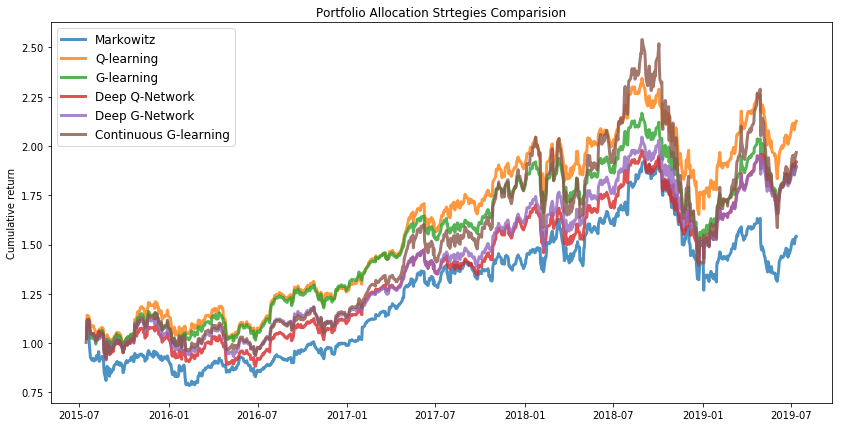

In [115]:
fig = plt.figure(figsize=(14, 7))
plt.plot(markowitz['Cum return'].index, markowitz['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(Q_returns['Cum return'].index, Q_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(G_returns['Cum return'].index, G_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(DQN_returns['Cum return'].index, DQN_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(DGN_returns['Cum return'].index, DGN_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.plot(ContinuousG_returns['Cum return'].index, ContinuousG_returns['Cum return'], lw=3, alpha=0.8,label=c)
plt.legend(labels = ('Markowitz', 'Q-learning', 'G-learning', 'Deep Q-Network', 'Deep G-Network', 
                     'Continuous G-learning'),loc='upper left', fontsize=12)
plt.ylabel('Cumulative return')
plt.title('Portfolio Allocation Strtegies Comparision')

In [116]:
fig.savefig("Portfolio Allocation Strtegies Comparision.pdf")